In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold

In [3]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation,BatchNormalization

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [5]:
from tqdm import tqdm
from tabulate import tabulate

In [6]:
# selecting random number of images from multiple folders and copying it to the destination folder
# Combined Prediction (take new sample and make combine data)

import os
import shutil
import glob
import random
# ctscan_covid_data = random.sample(glob.glob("Custom_Data/CT_Scan/Covid/CT_COVID/*.png"), 330)
# ctscan_normal_data = random.sample(glob.glob("Custom_Data/CT_Scan/Normal/CT_nonCOVID/*"), 330)

# ultrasound_covid_data = random.sample(glob.glob("Custom_Data/ultrasound/Covid/*"), 330)
# ultrasound_normal_data = random.sample(glob.glob("Custom_Data/ultrasound/Normal/*.jpg"), 330)

# xray_covid_data = random.sample(glob.glob("Custom_Data/X_ray/Covid/*.png"), 330)
# xray_normal_data = random.sample(glob.glob("Custom_Data/X_ray/Normal/*.png"), 330)

ctscan_covid_data = random.sample(glob.glob("Hamza_Custom_Data/CT_Scan/Covid/*.png"), 330)
ctscan_normal_data = random.sample(glob.glob("Hamza_Custom_Data/CT_Scan/Normal/*"), 330)   

ultrasound_covid_data = random.sample(glob.glob("Hamza_Custom_Data/Ultra_Sound/Covid/*"), 330)
ultrasound_normal_data = random.sample(glob.glob("Hamza_Custom_Data/Ultra_Sound/Normal/*.jpg"), 330)

xray_covid_data = random.sample(glob.glob("Hamza_Custom_Data/X_Ray/Covid/*.png"), 330)
xray_normal_data = random.sample(glob.glob("Hamza_Custom_Data/X_Ray/Normal/*.png"), 330)

covid_list=[ctscan_covid_data,ultrasound_covid_data,xray_covid_data]

normal_list = [ctscan_normal_data, ultrasound_normal_data,xray_normal_data]

if os.path.isdir('Data/Covid'):
    shutil.rmtree('Data/Covid')
    
if os.path.isdir('Data/Normal'):
    shutil.rmtree('Data/Normal')

for data in covid_list:
    dest = 'Data/Covid'
    if not os.path.isdir('Data/Covid'):
        os.makedirs(dest)
    for imgs in data:
        shutil.copy(imgs, dest)

for data in normal_list:
    dest = 'Data/Normal' 
    if not os.path.isdir('Data/Normal'):
          os.makedirs(dest)
    for imgs in data:
        shutil.copy(imgs, dest)

In [14]:
# pre-processing (image shape)
# X shape in 3 dimensions
# Y has 2 classes (Covid, Normal)
# make train and test data

class Dataset:
    def __init__(self, data_root: str, *, test_size: float, img_size: int, seed: int = 0) -> None:
        self.label2index = {}
        self.index2label = {}
        
        # Discover the class label names.
        class_labels = os.listdir(data_root)
        self.nclasses = len(class_labels)
        X, y = [], []
        
        for label_index, label in enumerate(class_labels):
            # Load the images for this class label.
            self.label2index[label_index] = label
            self.index2label[label] = label_index
            
            img_names = os.listdir(os.path.join(data_root, label))
            for img_name in img_names:
                img_path = os.path.join(data_root, label, img_name)
                img = load_img(img_path, target_size=(img_size, img_size, 3))
                X.append(img_to_array(img))
                y.append(label_index)
        
        X = np.array(X)
        y = np.array(y)
        one_hot_y = to_categorical(y, num_classes=self.nclasses)
        
        # Make a stratified split.
        self.X_train, self.X_test, self.labels_train, self.labels_test, self.y_train, self.y_test = train_test_split(
            X, y, one_hot_y, test_size=test_size, random_state=seed, stratify=y)

In [8]:
# (660*3) * 0.7 = 1386
import os
import shutil
import glob
import random
data = Dataset("Data/", test_size=0.3, img_size=224)
print(data.X_train.shape, data.y_train.shape)
print(data.X_test.shape, data.y_test.shape)

(1386, 224, 224, 3) (1386, 2)


In [10]:
# feature extractor model resnet 101 v2
model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r101x1/1", trainable=False)

In [11]:
covid_train_embedding = model(data.X_train)
covid_test_embedding = model(data.X_test)
print(covid_train_embedding.shape, covid_test_embedding.shape)

(1386, 2048) (594, 2048)


In [33]:
X_train_val = covid_train_embedding
y_train_val = data.y_train
data_train_labels = data.labels_train

In [38]:
X_test_val = covid_test_embedding
y_test_val = data.y_test
data_test_labels = data.labels_test

In [35]:
covid_train_embedding.shape

TensorShape([1386, 2048])

In [40]:
# Chaning shape for CNN2D
# for 2048 - > [-1,2,2,512]
# for 1280 - > [-1,2,2,320]

covid_train_embedding2d = tf.reshape(covid_train_embedding, [-1,2,2,512])
print(covid_train_embedding2d.shape)

covid_test_embedding2d = tf.reshape(covid_test_embedding, [-1,2,2,512])
print(covid_test_embedding2d.shape)

X_train_val = covid_train_embedding2d
X_test_val = covid_test_embedding2d

(1386, 2, 2, 512)
(594, 2, 2, 512)


### Graph Method for Resnet 101 v2

In [37]:
print(X_train_val.shape)
print(y_train_val.shape)
print(data_train_labels.shape)

(1386, 2, 2, 512)
(1386, 2)
(1386,)


In [41]:
print(X_test_val.shape)
print(y_test_val.shape)
print(data_test_labels.shape)

(594, 2, 2, 512)
(594, 2)
(594,)


In [42]:
# test train split

#Define Model
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding='same', input_shape=(2,2,512), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(1,1))
model.add(Conv2D(24, (3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(1,1))
model.add(Conv2D(32, (3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(1,1))
model.add(Conv2D(48, (3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(1,1))
model.add(Conv2D(64, (3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(1,1))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128,activation="relu"))
model.add(Dense(y_train_val.shape[1], activation="sigmoid"))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

history = model.fit(X_train_val, y_train_val, epochs=32, batch_size=16, verbose=2, validation_data=(X_test_val, y_test_val))

train_loss, train_acc = model.evaluate(X_train_val, y_train_val, verbose=0)
test_loss, test_acc = model.evaluate(X_test_val, y_test_val, verbose=0)

Epoch 1/32
87/87 - 19s - loss: 0.6295 - accuracy: 0.6696 - val_loss: 0.6330 - val_accuracy: 0.5303
Epoch 2/32
87/87 - 12s - loss: 0.4874 - accuracy: 0.7684 - val_loss: 0.5797 - val_accuracy: 0.6801
Epoch 3/32
87/87 - 12s - loss: 0.4350 - accuracy: 0.8232 - val_loss: 0.4089 - val_accuracy: 0.7963
Epoch 4/32
87/87 - 13s - loss: 0.3446 - accuracy: 0.8564 - val_loss: 0.4494 - val_accuracy: 0.8182
Epoch 5/32
87/87 - 13s - loss: 0.3235 - accuracy: 0.8636 - val_loss: 0.3329 - val_accuracy: 0.8586
Epoch 6/32
87/87 - 11s - loss: 0.2988 - accuracy: 0.8651 - val_loss: 0.4025 - val_accuracy: 0.8148
Epoch 7/32
87/87 - 13s - loss: 0.3010 - accuracy: 0.8737 - val_loss: 0.3508 - val_accuracy: 0.8300
Epoch 8/32
87/87 - 14s - loss: 0.2591 - accuracy: 0.8860 - val_loss: 0.6038 - val_accuracy: 0.8064
Epoch 9/32
87/87 - 16s - loss: 0.2621 - accuracy: 0.8903 - val_loss: 0.3043 - val_accuracy: 0.8653
Epoch 10/32
87/87 - 13s - loss: 0.2522 - accuracy: 0.8983 - val_loss: 0.4288 - val_accuracy: 0.8114
Epoch 11/

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 2, 2, 16)          73744     
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 2, 16)          64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 24)          3480      
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 24)          96        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 24)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 32)          6

In [45]:
print("Train Loss: " + str(train_loss))
print("Train Accuracy: " + str(train_acc))

print("Test Loss: " + str(test_loss))
print("Test Accuracy: " + str(test_acc))

Train Loss: 0.05281266197562218
Train Accuracy: 0.9805194735527039
Test Loss: 0.30786779522895813
Test Accuracy: 0.8956229090690613


In [50]:
y_pred = model.predict(X_test_val)
y_pred1 = np.argmax(y_pred, axis=1)
y_test1 = np.argmax(y_test_val, axis=1)

print(accuracy_score(y_test1, y_pred1))
print(confusion_matrix(y_test1,y_pred1))
print(classification_report(y_test1,y_pred1))

0.8956228956228957
[[276  21]
 [ 41 256]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       297
           1       0.92      0.86      0.89       297

    accuracy                           0.90       594
   macro avg       0.90      0.90      0.90       594
weighted avg       0.90      0.90      0.90       594



In [59]:
model_history = []
train_accs, test_accs = [], []
nfolds = 10
nrepeats = 3
epochs = 32
batch_size = 16
learning_rate = 3e-3 #0.003

In [60]:
# With Cross validation using train data

# Train and evaluate the model for each fold.
fold = 1
for train_index, test_index in tqdm(
    RepeatedStratifiedKFold(n_splits = nfolds, n_repeats = nrepeats, random_state = 0).split(X_train_val, data_train_labels), \
    total = nfolds*nrepeats):

    # Select the data for this fold.
    X_train = tf.gather(X_train_val, train_index) 
    y_train = tf.gather(y_train_val, train_index)
    X_test = tf.gather(X_train_val, test_index)
    y_test = tf.gather(y_train_val, test_index)
    
    #Define Model
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (3,3), padding='same', input_shape=(2,2,512), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(24, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(32, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(48, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(64, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Flatten())
    model.add(Dense(128,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(y_train_val.shape[1], activation="sigmoid"))

    #Learning Rate
    steps_per_epoch = math.ceil(len(X_train) / batch_size)
    third_of_total_steps = math.floor(epochs * steps_per_epoch / 3)
    
    # Train and evaluate the model.
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                learning_rate,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the test set.
    model_history.append(model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, verbose=2, \
                         validation_data=(X_test, y_test)))
    train_loss, train_acc = model.evaluate(X_train, y_train, batch_size = batch_size, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size = batch_size, verbose=0)
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    fold += 1
    print(f"Fold# {fold} completed...")

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch 1/32
78/78 - 17s - loss: 0.7600 - accuracy: 0.5654 - val_loss: 0.6811 - val_accuracy: 0.5396
Epoch 2/32
78/78 - 11s - loss: 0.6096 - accuracy: 0.6680 - val_loss: 0.5660 - val_accuracy: 0.7410
Epoch 3/32
78/78 - 10s - loss: 0.4818 - accuracy: 0.7891 - val_loss: 0.4270 - val_accuracy: 0.7914
Epoch 4/32
78/78 - 11s - loss: 0.3784 - accuracy: 0.8228 - val_loss: 0.4214 - val_accuracy: 0.8273
Epoch 5/32
78/78 - 11s - loss: 0.3506 - accuracy: 0.8565 - val_loss: 0.3557 - val_accuracy: 0.8633
Epoch 6/32
78/78 - 10s - loss: 0.2947 - accuracy: 0.8861 - val_loss: 0.3899 - val_accuracy: 0.8129
Epoch 7/32
78/78 - 10s - loss: 0.3006 - accuracy: 0.8765 - val_loss: 0.3752 - val_accuracy: 0.8273
Epoch 8/32
78/78 - 11s - loss: 0.2811 - accuracy: 0.8949 - val_loss: 0.7961 - val_accuracy: 0.7626
Epoch 9/32
78/78 - 10s - loss: 0.2785 - accuracy: 0.8974 - val_loss: 0.7526 - val_accuracy: 0.7338
Epoch 10/32
78/78 - 10s - loss: 0.2822 - accuracy: 0.8877 - val_loss: 0.4221 - val_accuracy: 0.8417
Epoch 11/

  3%|██▋                                                                             | 1/30 [06:15<3:01:43, 376.00s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 24s - loss: 0.7598 - accuracy: 0.5613 - val_loss: 0.6084 - val_accuracy: 0.6043
Epoch 2/32
78/78 - 12s - loss: 0.6356 - accuracy: 0.6528 - val_loss: 0.6221 - val_accuracy: 0.6763
Epoch 3/32
78/78 - 16s - loss: 0.5005 - accuracy: 0.7819 - val_loss: 0.6254 - val_accuracy: 0.6978
Epoch 4/32
78/78 - 12s - loss: 0.4564 - accuracy: 0.8123 - val_loss: 0.4886 - val_accuracy: 0.7410
Epoch 5/32
78/78 - 11s - loss: 0.3859 - accuracy: 0.8332 - val_loss: 0.3524 - val_accuracy: 0.8633
Epoch 6/32
78/78 - 12s - loss: 0.3691 - accuracy: 0.8364 - val_loss: 0.6177 - val_accuracy: 0.7338
Epoch 7/32
78/78 - 15s - loss: 0.3351 - accuracy: 0.8693 - val_loss: 0.3366 - val_accuracy: 0.8561
Epoch 8/32
78/78 - 13s - loss: 0.2752 - accuracy: 0.8917 - val_loss: 0.3825 - val_accuracy: 0.8058
Epoch 9/32
78/78 - 13s - loss: 0.2818 - accuracy: 0.8941 - val_loss: 0.3668 - val_accuracy: 0.8921
Epoch 10/32
78/78 - 19s - loss: 0.2532 - accuracy: 0.9070 - val_loss: 0.3129 - val_accur

  7%|█████▎                                                                          | 2/30 [13:41<3:14:35, 416.98s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 21s - loss: 0.7519 - accuracy: 0.5309 - val_loss: 0.6541 - val_accuracy: 0.5755
Epoch 2/32
78/78 - 12s - loss: 0.6343 - accuracy: 0.6127 - val_loss: 0.6272 - val_accuracy: 0.5971
Epoch 3/32
78/78 - 12s - loss: 0.5336 - accuracy: 0.7265 - val_loss: 0.6158 - val_accuracy: 0.6115
Epoch 4/32
78/78 - 10s - loss: 0.4213 - accuracy: 0.8244 - val_loss: 0.5892 - val_accuracy: 0.7698
Epoch 5/32
78/78 - 10s - loss: 0.3895 - accuracy: 0.8404 - val_loss: 0.4919 - val_accuracy: 0.7410
Epoch 6/32
78/78 - 10s - loss: 0.3637 - accuracy: 0.8388 - val_loss: 0.3510 - val_accuracy: 0.8417
Epoch 7/32
78/78 - 12s - loss: 0.2644 - accuracy: 0.8917 - val_loss: 0.3771 - val_accuracy: 0.8201
Epoch 8/32
78/78 - 11s - loss: 0.2931 - accuracy: 0.8861 - val_loss: 0.4837 - val_accuracy: 0.8489
Epoch 9/32
78/78 - 10s - loss: 0.2320 - accuracy: 0.8974 - val_loss: 0.4033 - val_accuracy: 0.7626
Epoch 10/32
78/78 - 10s - loss: 0.2412 - accuracy: 0.9038 - val_loss: 0.3619 - val_accur

 10%|████████                                                                        | 3/30 [20:46<3:09:14, 420.54s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 21s - loss: 0.7361 - accuracy: 0.5798 - val_loss: 0.6815 - val_accuracy: 0.5827
Epoch 2/32
78/78 - 14s - loss: 0.6510 - accuracy: 0.6271 - val_loss: 0.6283 - val_accuracy: 0.6331
Epoch 3/32
78/78 - 13s - loss: 0.5382 - accuracy: 0.7314 - val_loss: 0.6648 - val_accuracy: 0.5612
Epoch 4/32
78/78 - 13s - loss: 0.4258 - accuracy: 0.8212 - val_loss: 1.0334 - val_accuracy: 0.6115
Epoch 5/32
78/78 - 15s - loss: 0.4179 - accuracy: 0.8308 - val_loss: 0.4062 - val_accuracy: 0.8273
Epoch 6/32
78/78 - 14s - loss: 0.3486 - accuracy: 0.8476 - val_loss: 0.3653 - val_accuracy: 0.8489
Epoch 7/32
78/78 - 11s - loss: 0.3867 - accuracy: 0.8412 - val_loss: 0.3966 - val_accuracy: 0.7986
Epoch 8/32
78/78 - 12s - loss: 0.3246 - accuracy: 0.8701 - val_loss: 0.4501 - val_accuracy: 0.7698
Epoch 9/32
78/78 - 13s - loss: 0.2883 - accuracy: 0.8741 - val_loss: 0.4256 - val_accuracy: 0.8201
Epoch 10/32
78/78 - 13s - loss: 0.2808 - accuracy: 0.8733 - val_loss: 0.4088 - val_accur

 13%|██████████▋                                                                     | 4/30 [27:43<3:01:41, 419.28s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 18s - loss: 0.7133 - accuracy: 0.6151 - val_loss: 0.5789 - val_accuracy: 0.6835
Epoch 2/32
78/78 - 11s - loss: 0.5222 - accuracy: 0.7402 - val_loss: 0.6180 - val_accuracy: 0.6475
Epoch 3/32
78/78 - 11s - loss: 0.4158 - accuracy: 0.8148 - val_loss: 0.4428 - val_accuracy: 0.7194
Epoch 4/32
78/78 - 11s - loss: 0.3734 - accuracy: 0.8420 - val_loss: 0.3983 - val_accuracy: 0.8129
Epoch 5/32
78/78 - 11s - loss: 0.3308 - accuracy: 0.8693 - val_loss: 0.3983 - val_accuracy: 0.7914
Epoch 6/32
78/78 - 11s - loss: 0.3160 - accuracy: 0.8733 - val_loss: 1.1871 - val_accuracy: 0.6115
Epoch 7/32
78/78 - 11s - loss: 0.2536 - accuracy: 0.9014 - val_loss: 0.4678 - val_accuracy: 0.7986
Epoch 8/32
78/78 - 11s - loss: 0.2765 - accuracy: 0.8998 - val_loss: 0.3953 - val_accuracy: 0.8489
Epoch 9/32
78/78 - 11s - loss: 0.2684 - accuracy: 0.8933 - val_loss: 0.7093 - val_accuracy: 0.7626
Epoch 10/32
78/78 - 11s - loss: 0.2201 - accuracy: 0.9062 - val_loss: 0.5604 - val_accur

 17%|█████████████▎                                                                  | 5/30 [34:09<2:49:42, 407.29s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 17s - loss: 0.7740 - accuracy: 0.5293 - val_loss: 0.6382 - val_accuracy: 0.6403
Epoch 2/32
78/78 - 12s - loss: 0.5996 - accuracy: 0.6744 - val_loss: 0.6052 - val_accuracy: 0.7050
Epoch 3/32
78/78 - 11s - loss: 0.5097 - accuracy: 0.7490 - val_loss: 0.3833 - val_accuracy: 0.8417
Epoch 4/32
78/78 - 11s - loss: 0.4065 - accuracy: 0.8172 - val_loss: 0.5510 - val_accuracy: 0.6978
Epoch 5/32
78/78 - 11s - loss: 0.3780 - accuracy: 0.8436 - val_loss: 0.6037 - val_accuracy: 0.7626
Epoch 6/32
78/78 - 11s - loss: 0.3094 - accuracy: 0.8653 - val_loss: 1.1586 - val_accuracy: 0.6978
Epoch 7/32
78/78 - 10s - loss: 0.3239 - accuracy: 0.8637 - val_loss: 0.4563 - val_accuracy: 0.7770
Epoch 8/32
78/78 - 11s - loss: 0.2792 - accuracy: 0.9006 - val_loss: 0.8912 - val_accuracy: 0.6619
Epoch 9/32
78/78 - 11s - loss: 0.2391 - accuracy: 0.9006 - val_loss: 0.2745 - val_accuracy: 0.8705
Epoch 10/32
78/78 - 11s - loss: 0.2281 - accuracy: 0.9070 - val_loss: 0.2736 - val_accur

 20%|████████████████                                                                | 6/30 [40:38<2:40:23, 400.97s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 18s - loss: 0.7475 - accuracy: 0.5817 - val_loss: 0.6568 - val_accuracy: 0.5725
Epoch 2/32
78/78 - 11s - loss: 0.5429 - accuracy: 0.7444 - val_loss: 0.5050 - val_accuracy: 0.7101
Epoch 3/32
78/78 - 11s - loss: 0.4503 - accuracy: 0.7981 - val_loss: 0.6052 - val_accuracy: 0.6884
Epoch 4/32
78/78 - 11s - loss: 0.4242 - accuracy: 0.8125 - val_loss: 0.7432 - val_accuracy: 0.6812
Epoch 5/32
78/78 - 11s - loss: 0.3809 - accuracy: 0.8429 - val_loss: 0.3605 - val_accuracy: 0.8261
Epoch 6/32
78/78 - 11s - loss: 0.4013 - accuracy: 0.8261 - val_loss: 0.2750 - val_accuracy: 0.8696
Epoch 7/32
78/78 - 11s - loss: 0.3738 - accuracy: 0.8590 - val_loss: 0.3261 - val_accuracy: 0.8768
Epoch 8/32
78/78 - 10s - loss: 0.3345 - accuracy: 0.8638 - val_loss: 0.3354 - val_accuracy: 0.8406
Epoch 9/32
78/78 - 11s - loss: 0.2986 - accuracy: 0.8878 - val_loss: 0.3901 - val_accuracy: 0.8188
Epoch 10/32
78/78 - 11s - loss: 0.3178 - accuracy: 0.8766 - val_loss: 0.4333 - val_accur

 23%|██████████████████▋                                                             | 7/30 [47:06<2:32:05, 396.74s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 17s - loss: 0.8003 - accuracy: 0.5080 - val_loss: 0.6561 - val_accuracy: 0.6449
Epoch 2/32
78/78 - 10s - loss: 0.5702 - accuracy: 0.7075 - val_loss: 0.6836 - val_accuracy: 0.5725
Epoch 3/32
78/78 - 12s - loss: 0.4803 - accuracy: 0.7861 - val_loss: 0.7147 - val_accuracy: 0.6087
Epoch 4/32
78/78 - 10s - loss: 0.3975 - accuracy: 0.8293 - val_loss: 1.1450 - val_accuracy: 0.6304
Epoch 5/32
78/78 - 11s - loss: 0.4338 - accuracy: 0.7965 - val_loss: 0.6482 - val_accuracy: 0.6812
Epoch 6/32
78/78 - 11s - loss: 0.3454 - accuracy: 0.8654 - val_loss: 0.4098 - val_accuracy: 0.8406
Epoch 7/32
78/78 - 11s - loss: 0.3004 - accuracy: 0.8726 - val_loss: 0.4328 - val_accuracy: 0.8188
Epoch 8/32
78/78 - 12s - loss: 0.2964 - accuracy: 0.8790 - val_loss: 0.4926 - val_accuracy: 0.7391
Epoch 9/32
78/78 - 12s - loss: 0.3069 - accuracy: 0.8694 - val_loss: 0.4525 - val_accuracy: 0.7609
Epoch 10/32
78/78 - 12s - loss: 0.2737 - accuracy: 0.8878 - val_loss: 1.4707 - val_accur

 27%|█████████████████████▎                                                          | 8/30 [53:39<2:24:58, 395.38s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 17s - loss: 0.7111 - accuracy: 0.5753 - val_loss: 0.6513 - val_accuracy: 0.6014
Epoch 2/32
78/78 - 11s - loss: 0.5260 - accuracy: 0.7428 - val_loss: 0.4663 - val_accuracy: 0.7899
Epoch 3/32
78/78 - 10s - loss: 0.4293 - accuracy: 0.8205 - val_loss: 0.4201 - val_accuracy: 0.8551
Epoch 4/32
78/78 - 11s - loss: 0.3949 - accuracy: 0.8429 - val_loss: 0.6271 - val_accuracy: 0.7391
Epoch 5/32
78/78 - 12s - loss: 0.3272 - accuracy: 0.8638 - val_loss: 0.4091 - val_accuracy: 0.8333
Epoch 6/32
78/78 - 11s - loss: 0.3242 - accuracy: 0.8718 - val_loss: 0.4682 - val_accuracy: 0.8188
Epoch 7/32
78/78 - 12s - loss: 0.2713 - accuracy: 0.8910 - val_loss: 0.4504 - val_accuracy: 0.8696
Epoch 8/32
78/78 - 11s - loss: 0.2580 - accuracy: 0.8958 - val_loss: 1.6017 - val_accuracy: 0.6304
Epoch 9/32
78/78 - 11s - loss: 0.2525 - accuracy: 0.8942 - val_loss: 0.3354 - val_accuracy: 0.8551
Epoch 10/32
78/78 - 11s - loss: 0.2413 - accuracy: 0.9127 - val_loss: 0.6070 - val_accur

 30%|███████████████████████▍                                                      | 9/30 [1:00:15<2:18:31, 395.77s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 22s - loss: 0.7268 - accuracy: 0.5817 - val_loss: 0.6681 - val_accuracy: 0.6014
Epoch 2/32
78/78 - 14s - loss: 0.5704 - accuracy: 0.7188 - val_loss: 0.5268 - val_accuracy: 0.7174
Epoch 3/32
78/78 - 14s - loss: 0.4866 - accuracy: 0.7837 - val_loss: 0.5051 - val_accuracy: 0.7174
Epoch 4/32
78/78 - 14s - loss: 0.4224 - accuracy: 0.8269 - val_loss: 0.4037 - val_accuracy: 0.7899
Epoch 5/32
78/78 - 14s - loss: 0.3238 - accuracy: 0.8630 - val_loss: 0.7859 - val_accuracy: 0.7319
Epoch 6/32
78/78 - 14s - loss: 0.3513 - accuracy: 0.8405 - val_loss: 0.4636 - val_accuracy: 0.8188
Epoch 7/32
78/78 - 14s - loss: 0.3284 - accuracy: 0.8630 - val_loss: 0.3799 - val_accuracy: 0.8478
Epoch 8/32
78/78 - 13s - loss: 0.3298 - accuracy: 0.8606 - val_loss: 0.5094 - val_accuracy: 0.8043
Epoch 9/32
78/78 - 14s - loss: 0.2638 - accuracy: 0.8934 - val_loss: 0.3246 - val_accuracy: 0.8696
Epoch 10/32
78/78 - 14s - loss: 0.2442 - accuracy: 0.8990 - val_loss: 0.5455 - val_accur

 33%|█████████████████████████▋                                                   | 10/30 [1:08:30<2:22:07, 426.36s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 22s - loss: 0.7160 - accuracy: 0.6215 - val_loss: 0.6584 - val_accuracy: 0.5755
Epoch 2/32
78/78 - 14s - loss: 0.5796 - accuracy: 0.6848 - val_loss: 0.5884 - val_accuracy: 0.6115
Epoch 3/32
78/78 - 14s - loss: 0.4679 - accuracy: 0.7971 - val_loss: 0.5527 - val_accuracy: 0.6547
Epoch 4/32
78/78 - 13s - loss: 0.3892 - accuracy: 0.8444 - val_loss: 0.3354 - val_accuracy: 0.8633
Epoch 5/32
78/78 - 14s - loss: 0.3516 - accuracy: 0.8476 - val_loss: 0.4043 - val_accuracy: 0.8633
Epoch 6/32
78/78 - 13s - loss: 0.3637 - accuracy: 0.8404 - val_loss: 0.3468 - val_accuracy: 0.8417
Epoch 7/32
78/78 - 13s - loss: 0.3470 - accuracy: 0.8565 - val_loss: 0.4705 - val_accuracy: 0.8849
Epoch 8/32
78/78 - 13s - loss: 0.3258 - accuracy: 0.8581 - val_loss: 0.3706 - val_accuracy: 0.8633
Epoch 9/32
78/78 - 14s - loss: 0.2967 - accuracy: 0.8789 - val_loss: 0.5521 - val_accuracy: 0.7698
Epoch 10/32
78/78 - 14s - loss: 0.2650 - accuracy: 0.8837 - val_loss: 0.4996 - val_accur

 37%|████████████████████████████▏                                                | 11/30 [1:16:27<2:19:54, 441.83s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 20s - loss: 0.7640 - accuracy: 0.5285 - val_loss: 0.6951 - val_accuracy: 0.5324
Epoch 2/32
78/78 - 13s - loss: 0.6092 - accuracy: 0.6399 - val_loss: 0.5944 - val_accuracy: 0.6043
Epoch 3/32
78/78 - 14s - loss: 0.5374 - accuracy: 0.7137 - val_loss: 0.5866 - val_accuracy: 0.6835
Epoch 4/32
78/78 - 13s - loss: 0.4608 - accuracy: 0.7875 - val_loss: 0.5263 - val_accuracy: 0.7050
Epoch 5/32
78/78 - 13s - loss: 0.4108 - accuracy: 0.8172 - val_loss: 0.3767 - val_accuracy: 0.8201
Epoch 6/32
78/78 - 13s - loss: 0.3454 - accuracy: 0.8396 - val_loss: 0.3644 - val_accuracy: 0.8561
Epoch 7/32
78/78 - 14s - loss: 0.2912 - accuracy: 0.8733 - val_loss: 0.3151 - val_accuracy: 0.8489
Epoch 8/32
78/78 - 14s - loss: 0.3046 - accuracy: 0.8669 - val_loss: 0.5117 - val_accuracy: 0.8201
Epoch 9/32
78/78 - 13s - loss: 0.2426 - accuracy: 0.8966 - val_loss: 0.4993 - val_accuracy: 0.8345
Epoch 10/32
78/78 - 14s - loss: 0.2388 - accuracy: 0.8949 - val_loss: 0.3811 - val_accur

 40%|██████████████████████████████▊                                              | 12/30 [1:24:25<2:15:51, 452.87s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 21s - loss: 0.7314 - accuracy: 0.5846 - val_loss: 0.6756 - val_accuracy: 0.5108
Epoch 2/32
78/78 - 13s - loss: 0.5683 - accuracy: 0.6816 - val_loss: 0.4801 - val_accuracy: 0.7338
Epoch 3/32
78/78 - 16s - loss: 0.4639 - accuracy: 0.7795 - val_loss: 0.3923 - val_accuracy: 0.8417
Epoch 4/32
78/78 - 14s - loss: 0.4184 - accuracy: 0.8316 - val_loss: 0.4249 - val_accuracy: 0.7626
Epoch 5/32
78/78 - 14s - loss: 0.3702 - accuracy: 0.8589 - val_loss: 0.3029 - val_accuracy: 0.8345
Epoch 6/32
78/78 - 13s - loss: 0.3140 - accuracy: 0.8621 - val_loss: 0.3814 - val_accuracy: 0.8058
Epoch 7/32
78/78 - 14s - loss: 0.3146 - accuracy: 0.8565 - val_loss: 0.2632 - val_accuracy: 0.9209
Epoch 8/32
78/78 - 13s - loss: 0.2643 - accuracy: 0.8957 - val_loss: 0.4870 - val_accuracy: 0.8129
Epoch 9/32
78/78 - 14s - loss: 0.2421 - accuracy: 0.8957 - val_loss: 0.2825 - val_accuracy: 0.9065
Epoch 10/32
78/78 - 14s - loss: 0.2503 - accuracy: 0.8869 - val_loss: 0.6408 - val_accur

 43%|█████████████████████████████████▎                                           | 13/30 [1:32:24<2:10:35, 460.90s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 22s - loss: 0.7279 - accuracy: 0.6006 - val_loss: 0.7378 - val_accuracy: 0.4964
Epoch 2/32
78/78 - 13s - loss: 0.5376 - accuracy: 0.7233 - val_loss: 0.5774 - val_accuracy: 0.7194
Epoch 3/32
78/78 - 13s - loss: 0.4549 - accuracy: 0.7923 - val_loss: 0.3877 - val_accuracy: 0.8273
Epoch 4/32
78/78 - 13s - loss: 0.4080 - accuracy: 0.8300 - val_loss: 2.4308 - val_accuracy: 0.5180
Epoch 5/32
78/78 - 14s - loss: 0.3599 - accuracy: 0.8428 - val_loss: 0.4156 - val_accuracy: 0.7986
Epoch 6/32
78/78 - 12s - loss: 0.3360 - accuracy: 0.8565 - val_loss: 0.3591 - val_accuracy: 0.8489
Epoch 7/32
78/78 - 14s - loss: 0.3529 - accuracy: 0.8500 - val_loss: 0.2798 - val_accuracy: 0.8633
Epoch 8/32
78/78 - 13s - loss: 0.2609 - accuracy: 0.9006 - val_loss: 0.2389 - val_accuracy: 0.8921
Epoch 9/32
78/78 - 13s - loss: 0.2821 - accuracy: 0.8957 - val_loss: 0.6735 - val_accuracy: 0.7626
Epoch 10/32
78/78 - 14s - loss: 0.2598 - accuracy: 0.8877 - val_loss: 0.2828 - val_accur

 47%|███████████████████████████████████▉                                         | 14/30 [1:39:26<1:59:46, 449.14s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 17s - loss: 0.7223 - accuracy: 0.5878 - val_loss: 0.6616 - val_accuracy: 0.6691
Epoch 2/32
78/78 - 11s - loss: 0.5286 - accuracy: 0.7450 - val_loss: 0.5677 - val_accuracy: 0.6906
Epoch 3/32
78/78 - 10s - loss: 0.4532 - accuracy: 0.7795 - val_loss: 0.5401 - val_accuracy: 0.6978
Epoch 4/32
78/78 - 11s - loss: 0.4081 - accuracy: 0.8228 - val_loss: 0.8626 - val_accuracy: 0.6331
Epoch 5/32
78/78 - 11s - loss: 0.3515 - accuracy: 0.8460 - val_loss: 0.7588 - val_accuracy: 0.7410
Epoch 6/32
78/78 - 10s - loss: 0.3026 - accuracy: 0.8829 - val_loss: 1.5939 - val_accuracy: 0.6403
Epoch 7/32
78/78 - 11s - loss: 0.3112 - accuracy: 0.8789 - val_loss: 0.9676 - val_accuracy: 0.6187
Epoch 8/32
78/78 - 11s - loss: 0.2965 - accuracy: 0.8693 - val_loss: 0.8565 - val_accuracy: 0.6835
Epoch 9/32
78/78 - 11s - loss: 0.2632 - accuracy: 0.8877 - val_loss: 0.3004 - val_accuracy: 0.8561
Epoch 10/32
78/78 - 12s - loss: 0.2520 - accuracy: 0.9022 - val_loss: 0.5800 - val_accur

 50%|██████████████████████████████████████▌                                      | 15/30 [1:46:32<1:50:30, 442.04s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 22s - loss: 0.7500 - accuracy: 0.5285 - val_loss: 0.6908 - val_accuracy: 0.4964
Epoch 2/32
78/78 - 14s - loss: 0.6028 - accuracy: 0.6504 - val_loss: 0.6702 - val_accuracy: 0.6331
Epoch 3/32
78/78 - 14s - loss: 0.5035 - accuracy: 0.7706 - val_loss: 0.4337 - val_accuracy: 0.7698
Epoch 4/32
78/78 - 14s - loss: 0.3915 - accuracy: 0.8324 - val_loss: 0.3809 - val_accuracy: 0.8417
Epoch 5/32
78/78 - 12s - loss: 0.3664 - accuracy: 0.8276 - val_loss: 0.3875 - val_accuracy: 0.8129
Epoch 6/32
78/78 - 14s - loss: 0.3370 - accuracy: 0.8669 - val_loss: 1.0866 - val_accuracy: 0.6115
Epoch 7/32
78/78 - 13s - loss: 0.2962 - accuracy: 0.8733 - val_loss: 0.4929 - val_accuracy: 0.8561
Epoch 8/32
78/78 - 11s - loss: 0.2961 - accuracy: 0.8557 - val_loss: 0.5113 - val_accuracy: 0.7770
Epoch 9/32
78/78 - 11s - loss: 0.2703 - accuracy: 0.8781 - val_loss: 0.3695 - val_accuracy: 0.8849
Epoch 10/32
78/78 - 12s - loss: 0.3103 - accuracy: 0.8589 - val_loss: 0.3293 - val_accur

 53%|█████████████████████████████████████████                                    | 16/30 [1:53:29<1:41:24, 434.61s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 17s - loss: 0.7791 - accuracy: 0.5377 - val_loss: 0.6767 - val_accuracy: 0.5000
Epoch 2/32
78/78 - 11s - loss: 0.6032 - accuracy: 0.6723 - val_loss: 0.5348 - val_accuracy: 0.7899
Epoch 3/32
78/78 - 11s - loss: 0.4494 - accuracy: 0.7877 - val_loss: 0.4203 - val_accuracy: 0.7826
Epoch 4/32
78/78 - 11s - loss: 0.4664 - accuracy: 0.7724 - val_loss: 0.3896 - val_accuracy: 0.8406
Epoch 5/32
78/78 - 11s - loss: 0.3944 - accuracy: 0.8285 - val_loss: 0.4558 - val_accuracy: 0.8188
Epoch 6/32
78/78 - 11s - loss: 0.3700 - accuracy: 0.8446 - val_loss: 0.9087 - val_accuracy: 0.6884
Epoch 7/32
78/78 - 11s - loss: 0.3239 - accuracy: 0.8694 - val_loss: 0.5210 - val_accuracy: 0.8406
Epoch 8/32
78/78 - 11s - loss: 0.3128 - accuracy: 0.8790 - val_loss: 0.4562 - val_accuracy: 0.7971
Epoch 9/32
78/78 - 11s - loss: 0.2534 - accuracy: 0.8990 - val_loss: 0.3654 - val_accuracy: 0.8768
Epoch 10/32
78/78 - 11s - loss: 0.2315 - accuracy: 0.8838 - val_loss: 0.8654 - val_accur

 57%|███████████████████████████████████████████▋                                 | 17/30 [1:59:53<1:30:52, 419.40s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 17s - loss: 0.7177 - accuracy: 0.5905 - val_loss: 0.6616 - val_accuracy: 0.5942
Epoch 2/32
78/78 - 11s - loss: 0.5614 - accuracy: 0.7179 - val_loss: 0.5881 - val_accuracy: 0.6739
Epoch 3/32
78/78 - 11s - loss: 0.4665 - accuracy: 0.7861 - val_loss: 0.5068 - val_accuracy: 0.7101
Epoch 4/32
78/78 - 12s - loss: 0.4008 - accuracy: 0.8101 - val_loss: 0.6327 - val_accuracy: 0.7101
Epoch 5/32
78/78 - 11s - loss: 0.4171 - accuracy: 0.8077 - val_loss: 0.5322 - val_accuracy: 0.7609
Epoch 6/32
78/78 - 11s - loss: 0.3986 - accuracy: 0.8397 - val_loss: 0.5562 - val_accuracy: 0.7174
Epoch 7/32
78/78 - 11s - loss: 0.3240 - accuracy: 0.8646 - val_loss: 0.3870 - val_accuracy: 0.8551
Epoch 8/32
78/78 - 11s - loss: 0.3166 - accuracy: 0.8734 - val_loss: 0.3995 - val_accuracy: 0.8043
Epoch 9/32
78/78 - 11s - loss: 0.3224 - accuracy: 0.8862 - val_loss: 0.4466 - val_accuracy: 0.7754
Epoch 10/32
78/78 - 11s - loss: 0.2992 - accuracy: 0.8742 - val_loss: 0.6976 - val_accur

 60%|██████████████████████████████████████████████▏                              | 18/30 [2:06:21<1:21:57, 409.75s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 16s - loss: 0.7284 - accuracy: 0.5785 - val_loss: 0.6414 - val_accuracy: 0.6667
Epoch 2/32
78/78 - 11s - loss: 0.5537 - accuracy: 0.7348 - val_loss: 0.5737 - val_accuracy: 0.6522
Epoch 3/32
78/78 - 11s - loss: 0.4705 - accuracy: 0.7668 - val_loss: 0.4275 - val_accuracy: 0.8116
Epoch 4/32
78/78 - 11s - loss: 0.3678 - accuracy: 0.8365 - val_loss: 0.3700 - val_accuracy: 0.8188
Epoch 5/32
78/78 - 10s - loss: 0.3446 - accuracy: 0.8526 - val_loss: 0.4314 - val_accuracy: 0.8116
Epoch 6/32
78/78 - 11s - loss: 0.3256 - accuracy: 0.8534 - val_loss: 0.5992 - val_accuracy: 0.7826
Epoch 7/32
78/78 - 11s - loss: 0.3020 - accuracy: 0.8734 - val_loss: 0.9059 - val_accuracy: 0.6159
Epoch 8/32
78/78 - 11s - loss: 0.2780 - accuracy: 0.8838 - val_loss: 0.4264 - val_accuracy: 0.7971
Epoch 9/32
78/78 - 11s - loss: 0.2483 - accuracy: 0.8982 - val_loss: 0.3272 - val_accuracy: 0.8841
Epoch 10/32
78/78 - 11s - loss: 0.2693 - accuracy: 0.8742 - val_loss: 0.4215 - val_accur

 63%|████████████████████████████████████████████████▊                            | 19/30 [2:12:46<1:13:46, 402.44s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 18s - loss: 0.7498 - accuracy: 0.5617 - val_loss: 0.6695 - val_accuracy: 0.6232
Epoch 2/32
78/78 - 11s - loss: 0.6225 - accuracy: 0.6098 - val_loss: 0.6089 - val_accuracy: 0.6594
Epoch 3/32
78/78 - 11s - loss: 0.5176 - accuracy: 0.7236 - val_loss: 0.5753 - val_accuracy: 0.6522
Epoch 4/32
78/78 - 11s - loss: 0.5075 - accuracy: 0.7676 - val_loss: 0.4887 - val_accuracy: 0.8043
Epoch 5/32
78/78 - 10s - loss: 0.4123 - accuracy: 0.8189 - val_loss: 0.6676 - val_accuracy: 0.6812
Epoch 6/32
78/78 - 11s - loss: 0.3823 - accuracy: 0.8518 - val_loss: 0.6128 - val_accuracy: 0.7609
Epoch 7/32
78/78 - 11s - loss: 0.3325 - accuracy: 0.8750 - val_loss: 0.3998 - val_accuracy: 0.7971
Epoch 8/32
78/78 - 10s - loss: 0.3209 - accuracy: 0.8542 - val_loss: 0.3959 - val_accuracy: 0.8043
Epoch 9/32
78/78 - 9s - loss: 0.2624 - accuracy: 0.8878 - val_loss: 0.4112 - val_accuracy: 0.7971
Epoch 10/32
78/78 - 11s - loss: 0.2845 - accuracy: 0.8870 - val_loss: 0.3198 - val_accura

 67%|███████████████████████████████████████████████████▎                         | 20/30 [2:19:13<1:06:18, 397.84s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 17s - loss: 0.7658 - accuracy: 0.5597 - val_loss: 0.7177 - val_accuracy: 0.5108
Epoch 2/32
78/78 - 11s - loss: 0.6081 - accuracy: 0.6704 - val_loss: 0.5780 - val_accuracy: 0.6691
Epoch 3/32
78/78 - 12s - loss: 0.4709 - accuracy: 0.7739 - val_loss: 0.6551 - val_accuracy: 0.6187
Epoch 4/32
78/78 - 11s - loss: 0.4204 - accuracy: 0.8107 - val_loss: 0.5015 - val_accuracy: 0.7410
Epoch 5/32
78/78 - 10s - loss: 0.3893 - accuracy: 0.8396 - val_loss: 0.3860 - val_accuracy: 0.8561
Epoch 6/32
78/78 - 11s - loss: 0.3943 - accuracy: 0.8260 - val_loss: 0.5510 - val_accuracy: 0.7338
Epoch 7/32
78/78 - 11s - loss: 0.3283 - accuracy: 0.8669 - val_loss: 0.4126 - val_accuracy: 0.7986
Epoch 8/32
78/78 - 11s - loss: 0.3367 - accuracy: 0.8468 - val_loss: 0.3855 - val_accuracy: 0.8561
Epoch 9/32
78/78 - 10s - loss: 0.2789 - accuracy: 0.8789 - val_loss: 0.2701 - val_accuracy: 0.8777
Epoch 10/32
78/78 - 11s - loss: 0.2881 - accuracy: 0.8901 - val_loss: 0.5260 - val_accur

 70%|███████████████████████████████████████████████████████▎                       | 21/30 [2:25:36<59:00, 393.38s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 17s - loss: 0.7862 - accuracy: 0.5044 - val_loss: 0.6896 - val_accuracy: 0.5036
Epoch 2/32
78/78 - 11s - loss: 0.6791 - accuracy: 0.5678 - val_loss: 0.6415 - val_accuracy: 0.6403
Epoch 3/32
78/78 - 12s - loss: 0.5531 - accuracy: 0.7322 - val_loss: 0.4751 - val_accuracy: 0.7626
Epoch 4/32
78/78 - 12s - loss: 0.4320 - accuracy: 0.8067 - val_loss: 0.4854 - val_accuracy: 0.7698
Epoch 5/32
78/78 - 11s - loss: 0.4209 - accuracy: 0.8164 - val_loss: 0.5204 - val_accuracy: 0.7842
Epoch 6/32
78/78 - 11s - loss: 0.3953 - accuracy: 0.8268 - val_loss: 0.4719 - val_accuracy: 0.7122
Epoch 7/32
78/78 - 11s - loss: 0.3685 - accuracy: 0.8316 - val_loss: 0.3836 - val_accuracy: 0.8129
Epoch 8/32
78/78 - 11s - loss: 0.2989 - accuracy: 0.8773 - val_loss: 0.4230 - val_accuracy: 0.8345
Epoch 9/32
78/78 - 11s - loss: 0.2691 - accuracy: 0.8957 - val_loss: 0.4791 - val_accuracy: 0.8129
Epoch 10/32
78/78 - 12s - loss: 0.2456 - accuracy: 0.8974 - val_loss: 0.5924 - val_accur

 73%|█████████████████████████████████████████████████████████▉                     | 22/30 [2:32:07<52:21, 392.69s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 17s - loss: 0.7302 - accuracy: 0.5710 - val_loss: 0.6841 - val_accuracy: 0.5468
Epoch 2/32
78/78 - 12s - loss: 0.5496 - accuracy: 0.7281 - val_loss: 0.5451 - val_accuracy: 0.7626
Epoch 3/32
78/78 - 11s - loss: 0.4526 - accuracy: 0.8003 - val_loss: 0.5299 - val_accuracy: 0.7338
Epoch 4/32
78/78 - 11s - loss: 0.3832 - accuracy: 0.8444 - val_loss: 0.3623 - val_accuracy: 0.8201
Epoch 5/32
78/78 - 12s - loss: 0.3596 - accuracy: 0.8557 - val_loss: 0.4366 - val_accuracy: 0.8058
Epoch 6/32
78/78 - 11s - loss: 0.3317 - accuracy: 0.8557 - val_loss: 0.8360 - val_accuracy: 0.7482
Epoch 7/32
78/78 - 11s - loss: 0.3232 - accuracy: 0.8765 - val_loss: 0.4070 - val_accuracy: 0.8058
Epoch 8/32
78/78 - 11s - loss: 0.2427 - accuracy: 0.8998 - val_loss: 0.3053 - val_accuracy: 0.8633
Epoch 9/32
78/78 - 11s - loss: 0.2834 - accuracy: 0.8861 - val_loss: 0.6802 - val_accuracy: 0.7410
Epoch 10/32
78/78 - 11s - loss: 0.2676 - accuracy: 0.8893 - val_loss: 0.4024 - val_accur

 77%|████████████████████████████████████████████████████████████▌                  | 23/30 [2:38:38<45:44, 392.08s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 18s - loss: 0.7336 - accuracy: 0.5854 - val_loss: 0.6486 - val_accuracy: 0.6763
Epoch 2/32
78/78 - 10s - loss: 0.5544 - accuracy: 0.7001 - val_loss: 0.6193 - val_accuracy: 0.6115
Epoch 3/32
78/78 - 11s - loss: 0.4692 - accuracy: 0.7650 - val_loss: 0.9495 - val_accuracy: 0.6331
Epoch 4/32
78/78 - 10s - loss: 0.4071 - accuracy: 0.8292 - val_loss: 0.4939 - val_accuracy: 0.8201
Epoch 5/32
78/78 - 11s - loss: 0.3608 - accuracy: 0.8476 - val_loss: 0.3035 - val_accuracy: 0.8345
Epoch 6/32
78/78 - 11s - loss: 0.3344 - accuracy: 0.8484 - val_loss: 0.3695 - val_accuracy: 0.8561
Epoch 7/32
78/78 - 11s - loss: 0.2934 - accuracy: 0.8765 - val_loss: 0.2761 - val_accuracy: 0.8777
Epoch 8/32
78/78 - 10s - loss: 0.3047 - accuracy: 0.8765 - val_loss: 1.1036 - val_accuracy: 0.7338
Epoch 9/32
78/78 - 10s - loss: 0.2880 - accuracy: 0.8765 - val_loss: 0.6958 - val_accuracy: 0.7698
Epoch 10/32
78/78 - 11s - loss: 0.2561 - accuracy: 0.8901 - val_loss: 0.3023 - val_accur

 80%|███████████████████████████████████████████████████████████████▏               | 24/30 [2:45:00<38:53, 388.95s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 18s - loss: 0.7625 - accuracy: 0.5734 - val_loss: 0.6527 - val_accuracy: 0.5827
Epoch 2/32
78/78 - 11s - loss: 0.5711 - accuracy: 0.6961 - val_loss: 0.6324 - val_accuracy: 0.6331
Epoch 3/32
78/78 - 11s - loss: 0.4803 - accuracy: 0.7883 - val_loss: 1.6554 - val_accuracy: 0.6043
Epoch 4/32
78/78 - 11s - loss: 0.4101 - accuracy: 0.8140 - val_loss: 0.3624 - val_accuracy: 0.8489
Epoch 5/32
78/78 - 10s - loss: 0.3610 - accuracy: 0.8452 - val_loss: 0.4872 - val_accuracy: 0.7482
Epoch 6/32
78/78 - 11s - loss: 0.2948 - accuracy: 0.8805 - val_loss: 1.0509 - val_accuracy: 0.6403
Epoch 7/32
78/78 - 11s - loss: 0.2674 - accuracy: 0.8957 - val_loss: 0.3359 - val_accuracy: 0.8705
Epoch 8/32
78/78 - 11s - loss: 0.3045 - accuracy: 0.8733 - val_loss: 0.3534 - val_accuracy: 0.8489
Epoch 9/32
78/78 - 10s - loss: 0.3479 - accuracy: 0.8484 - val_loss: 0.7058 - val_accuracy: 0.8058
Epoch 10/32
78/78 - 11s - loss: 0.3355 - accuracy: 0.8733 - val_loss: 0.7651 - val_accur

 83%|█████████████████████████████████████████████████████████████████▊             | 25/30 [2:51:27<32:22, 388.44s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 17s - loss: 0.6970 - accuracy: 0.6167 - val_loss: 0.6941 - val_accuracy: 0.4964
Epoch 2/32
78/78 - 11s - loss: 0.5075 - accuracy: 0.7602 - val_loss: 0.4602 - val_accuracy: 0.8058
Epoch 3/32
78/78 - 11s - loss: 0.4631 - accuracy: 0.7923 - val_loss: 0.4943 - val_accuracy: 0.7626
Epoch 4/32
78/78 - 11s - loss: 0.3814 - accuracy: 0.8396 - val_loss: 0.4125 - val_accuracy: 0.7842
Epoch 5/32
78/78 - 11s - loss: 0.3428 - accuracy: 0.8605 - val_loss: 0.6487 - val_accuracy: 0.7338
Epoch 6/32
78/78 - 11s - loss: 0.3259 - accuracy: 0.8693 - val_loss: 0.4107 - val_accuracy: 0.8345
Epoch 7/32
78/78 - 12s - loss: 0.3213 - accuracy: 0.8685 - val_loss: 0.7125 - val_accuracy: 0.6619
Epoch 8/32
78/78 - 11s - loss: 0.2922 - accuracy: 0.8661 - val_loss: 0.3097 - val_accuracy: 0.8417
Epoch 9/32
78/78 - 11s - loss: 0.2613 - accuracy: 0.9038 - val_loss: 0.7548 - val_accuracy: 0.7050
Epoch 10/32
78/78 - 11s - loss: 0.2520 - accuracy: 0.8998 - val_loss: 0.3004 - val_accur

 87%|████████████████████████████████████████████████████████████████████▍          | 26/30 [2:57:54<25:52, 388.01s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 17s - loss: 0.7314 - accuracy: 0.5769 - val_loss: 0.6393 - val_accuracy: 0.5000
Epoch 2/32
78/78 - 11s - loss: 0.5129 - accuracy: 0.7404 - val_loss: 0.4265 - val_accuracy: 0.7971
Epoch 3/32
78/78 - 11s - loss: 0.4405 - accuracy: 0.8013 - val_loss: 0.4449 - val_accuracy: 0.7971
Epoch 4/32
78/78 - 11s - loss: 0.3805 - accuracy: 0.8478 - val_loss: 0.2533 - val_accuracy: 0.8768
Epoch 5/32
78/78 - 11s - loss: 0.3235 - accuracy: 0.8646 - val_loss: 1.2121 - val_accuracy: 0.5145
Epoch 6/32
78/78 - 11s - loss: 0.3303 - accuracy: 0.8590 - val_loss: 0.3638 - val_accuracy: 0.8623
Epoch 7/32
78/78 - 11s - loss: 0.3188 - accuracy: 0.8734 - val_loss: 0.2337 - val_accuracy: 0.8986
Epoch 8/32
78/78 - 11s - loss: 0.2770 - accuracy: 0.8758 - val_loss: 0.2969 - val_accuracy: 0.8696
Epoch 9/32
78/78 - 11s - loss: 0.2534 - accuracy: 0.8958 - val_loss: 0.2747 - val_accuracy: 0.8768
Epoch 10/32
78/78 - 12s - loss: 0.2341 - accuracy: 0.9046 - val_loss: 0.3271 - val_accur

 90%|███████████████████████████████████████████████████████████████████████        | 27/30 [3:04:17<19:19, 386.53s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 17s - loss: 0.7160 - accuracy: 0.5657 - val_loss: 0.6515 - val_accuracy: 0.6159
Epoch 2/32
78/78 - 11s - loss: 0.5984 - accuracy: 0.6819 - val_loss: 0.6013 - val_accuracy: 0.6884
Epoch 3/32
78/78 - 11s - loss: 0.4455 - accuracy: 0.7885 - val_loss: 0.3776 - val_accuracy: 0.8261
Epoch 4/32
78/78 - 11s - loss: 0.4159 - accuracy: 0.8045 - val_loss: 0.8839 - val_accuracy: 0.6304
Epoch 5/32
78/78 - 11s - loss: 0.3496 - accuracy: 0.8462 - val_loss: 0.5974 - val_accuracy: 0.7029
Epoch 6/32
78/78 - 11s - loss: 0.2997 - accuracy: 0.8798 - val_loss: 0.2582 - val_accuracy: 0.8696
Epoch 7/32
78/78 - 11s - loss: 0.2701 - accuracy: 0.8894 - val_loss: 0.3688 - val_accuracy: 0.8623
Epoch 8/32
78/78 - 10s - loss: 0.2473 - accuracy: 0.9006 - val_loss: 0.4082 - val_accuracy: 0.8623
Epoch 9/32
78/78 - 12s - loss: 0.2479 - accuracy: 0.9079 - val_loss: 0.3047 - val_accuracy: 0.8478
Epoch 10/32
78/78 - 11s - loss: 0.2599 - accuracy: 0.8838 - val_loss: 0.3882 - val_accur

 93%|█████████████████████████████████████████████████████████████████████████▋     | 28/30 [3:10:47<12:55, 387.56s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 16s - loss: 0.7295 - accuracy: 0.5938 - val_loss: 0.6443 - val_accuracy: 0.6087
Epoch 2/32
78/78 - 11s - loss: 0.5084 - accuracy: 0.7644 - val_loss: 0.5323 - val_accuracy: 0.8116
Epoch 3/32
78/78 - 11s - loss: 0.3972 - accuracy: 0.8293 - val_loss: 0.4147 - val_accuracy: 0.8261
Epoch 4/32
78/78 - 11s - loss: 0.3756 - accuracy: 0.8510 - val_loss: 0.4673 - val_accuracy: 0.7899
Epoch 5/32
78/78 - 11s - loss: 0.3314 - accuracy: 0.8694 - val_loss: 0.3650 - val_accuracy: 0.8333
Epoch 6/32
78/78 - 12s - loss: 0.3330 - accuracy: 0.8582 - val_loss: 0.7161 - val_accuracy: 0.6739
Epoch 7/32
78/78 - 10s - loss: 0.2920 - accuracy: 0.8886 - val_loss: 0.3776 - val_accuracy: 0.8696
Epoch 8/32
78/78 - 11s - loss: 0.3053 - accuracy: 0.8718 - val_loss: 0.5816 - val_accuracy: 0.7899
Epoch 9/32
78/78 - 10s - loss: 0.2438 - accuracy: 0.9014 - val_loss: 0.3242 - val_accuracy: 0.8696
Epoch 10/32
78/78 - 11s - loss: 0.2044 - accuracy: 0.9095 - val_loss: 0.4431 - val_accur

 97%|████████████████████████████████████████████████████████████████████████████▎  | 29/30 [3:17:15<06:27, 387.70s/it]

Fold# 1 completed...
Epoch 1/32
78/78 - 18s - loss: 0.7608 - accuracy: 0.5817 - val_loss: 0.7169 - val_accuracy: 0.5725
Epoch 2/32
78/78 - 12s - loss: 0.5606 - accuracy: 0.6979 - val_loss: 0.4670 - val_accuracy: 0.7826
Epoch 3/32
78/78 - 11s - loss: 0.4271 - accuracy: 0.8021 - val_loss: 0.5752 - val_accuracy: 0.7464
Epoch 4/32
78/78 - 11s - loss: 0.4038 - accuracy: 0.8301 - val_loss: 0.3776 - val_accuracy: 0.7971
Epoch 5/32
78/78 - 12s - loss: 0.3337 - accuracy: 0.8582 - val_loss: 0.5211 - val_accuracy: 0.7826
Epoch 6/32
78/78 - 10s - loss: 0.3271 - accuracy: 0.8566 - val_loss: 0.3994 - val_accuracy: 0.8551
Epoch 7/32
78/78 - 10s - loss: 0.2410 - accuracy: 0.8966 - val_loss: 0.3329 - val_accuracy: 0.8333
Epoch 8/32
78/78 - 11s - loss: 0.2324 - accuracy: 0.9046 - val_loss: 0.3988 - val_accuracy: 0.8623
Epoch 9/32
78/78 - 11s - loss: 0.3001 - accuracy: 0.8758 - val_loss: 0.6856 - val_accuracy: 0.7899
Epoch 10/32
78/78 - 11s - loss: 0.2750 - accuracy: 0.9038 - val_loss: 0.3978 - val_accur

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [3:23:42<00:00, 407.40s/it]

Fold# 1 completed...


In [61]:
# Aggregate.
results = {
    "Train_Acc": np.mean(train_accs),
    "Train_std": np.std(train_accs),
    "Test_Acc": np.mean(test_accs),
    "Test_std": np.std(test_accs)
}

In [62]:
print(
    tabulate(
            [
                ["Train", results["Train_Acc"], results["Train_std"]],
                ["Test", results["Test_Acc"], results["Test_std"]]
            ],
            headers=["Set", "Accuracy", "Standard Deviation"]
        )
    )

Set      Accuracy    Standard Deviation
-----  ----------  --------------------
Train    0.987815            0.00480331
Test     0.888646            0.0197107


In [36]:
# ploting graph by using values of last epoch for graphs
from matplotlib import pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy value (%)')
    plt.xlabel('No. epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend()

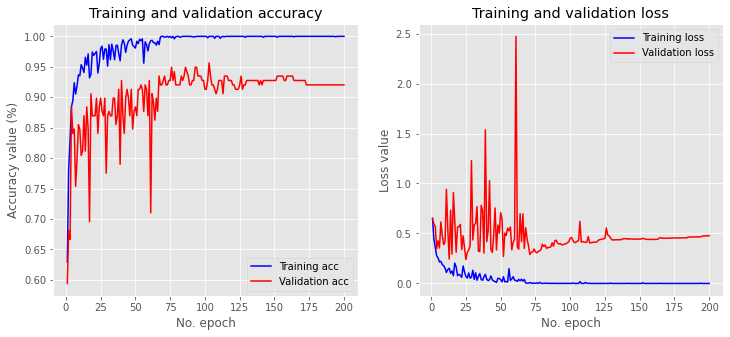

In [37]:
plot_history(history)

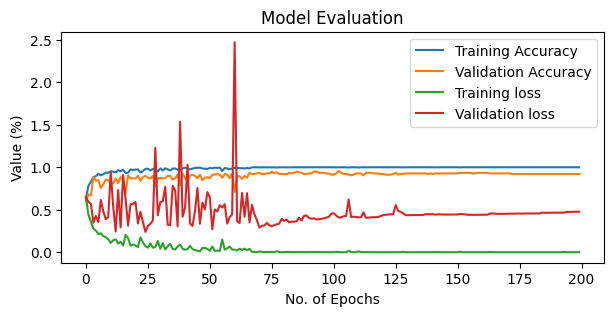

In [38]:
#All in one Graph (loss and accuracy)
plt.style.use('default')
plt.figure(figsize=(7, 3))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"]) 
plt.title("Model Evaluation")
plt.ylabel("Value (%)")
plt.xlabel("No. of Epochs")
plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation loss"])
plt.show()

In [42]:
#These confussion matrix are not correct
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test1 = np.argmax(y_test, axis=1)

print(accuracy_score(y_test1, y_pred))
#print(confusion_matrix(y_test,y_pred))
#print(classification_report(y_test,y_pred))

5/5 [==============================] - 0s 4ms/step
0.9202898550724637
